In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier

## 設定

In [2]:
pattern_date = '2023-12-24'
root_dir = f'{"/".join(os.getcwd().split("/")[:-1])}'
highplace_emb_dir = f'{root_dir}/data/outputs/04.highplace_detection/01.gpt4_text_and_emb'
highplace_model_dir = f'{root_dir}/data/outputs/04.highplace_detection/03.gpt4_pred_highplace_detection'
result_dir = f'{root_dir}/data/outputs/04.highplace_detection/05.gpt4_pred_highplace_detection'

In [3]:
pred_person_highplace_df = pd.read_csv(f'{highplace_emb_dir}/person_eval_pred_message_and_emb-{pattern_date}.csv')

In [4]:
class_category = [
    'detection-miss',
    'person',
    'person in high place',
]
no_alarm_class_category = [
    'detection-miss',
    'person',
]

## 高さ検知の推論実行

In [5]:
def classname2number(label_name):
    for idx, category in enumerate(class_category):
        if label_name == category:
            return idx

### cross-validationでの評価

In [6]:
labels_list = []
prob_list = []
valid_all_df_list = []
for num_cv in range(3):
    valid_df = pred_person_highplace_df[
        (pred_person_highplace_df['validation'] == num_cv) &
        (
            (pred_person_highplace_df['unique_key'].str.contains('fixed-point-camera')) |
            (pred_person_highplace_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
            (pred_person_highplace_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
        )
    ]
    valid_all_df_list.append(valid_df)
    model = CatBoostClassifier()
    model.load_model(f'{highplace_model_dir}/{num_cv}/catboost.cbm')

    labels_np = valid_df['label'].apply(classname2number).values
    prob_np = model.predict(valid_df.iloc[:, 12:].values, prediction_type='Probability')
    labels_list.append(labels_np)
    prob_list.append(prob_np)

labels_np = np.concatenate(labels_list)
prob_np = np.concatenate(prob_list)
prob_argmax = np.argmax(prob_np, axis=1)
valid_all_df = pd.concat(valid_all_df_list)

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [7]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=class_category, columns=class_category
))

,detection-miss,person,person in high place
detection-miss,2,169,22
person,11,1655,65
person in high place,2,39,40


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [8]:
def pred_class_names_precision095(row):
    no_safetybelt_threshold = row['threshold - person in high place']
    if row['person in high place'] >= no_safetybelt_threshold:
        return 'person in high place'
    return row[no_alarm_class_category].idxmax()

In [9]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
for num_cv in range(3):
    threshold_precision095_valid_dict = {}
    for class_num, class_names in enumerate(class_category):
        if class_names in no_alarm_class_category:
            continue
        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        _threshold = 1.0
        for p, t in zip(precisions, thresholds):
            if p >= 0.65:
                _threshold = t
                break
        threshold_precision095_valid_dict[class_names] = _threshold
    threshold_precision095_df_list.append(pd.DataFrame(
        [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(valid_all_df[valid_all_df['validation'] == num_cv]))],
        columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
    ))
threshold_precision095_df = pd.concat(threshold_precision095_df_list).reset_index(drop=True)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=class_category), threshold_precision095_df], axis=1)

In [10]:
valid_all_df['pred_person_in_highplace_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

In [11]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(valid_all_df['pred_person_in_highplace_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=class_category, columns=class_category
))

,detection-miss,person,person in high place
detection-miss,4,188,1
person,18,1713,0
person in high place,8,71,2


#### PR-AUC

validation: 0
person in high place - PR-AUC: 0.2651
precision@0.60 - Recall: 0.0000 - Threshold: 0.0000
precision@0.65 - Recall: 0.0000 - Threshold: 0.0000 



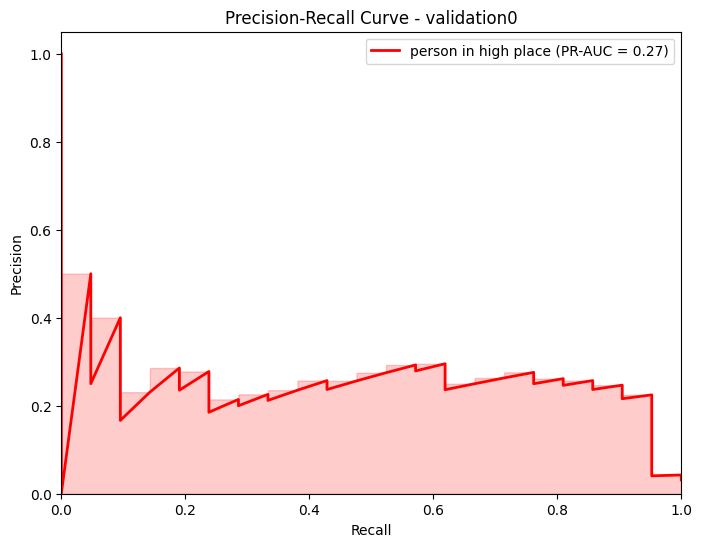

validation: 1
person in high place - PR-AUC: 0.3585
precision@0.64 - Recall: 0.2188 - Threshold: 0.6253
precision@0.67 - Recall: 0.0625 - Threshold: 0.7865 



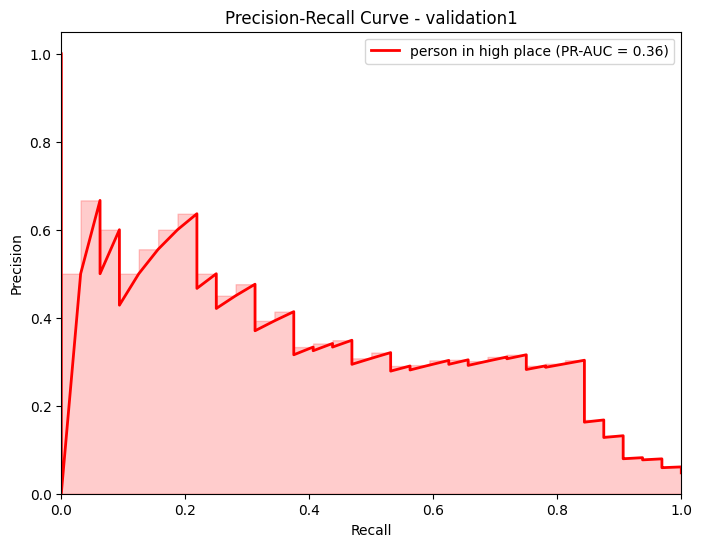

validation: 2
person in high place - PR-AUC: 0.2591
precision@0.60 - Recall: 0.0000 - Threshold: 0.0000
precision@0.65 - Recall: 0.0000 - Threshold: 0.0000 



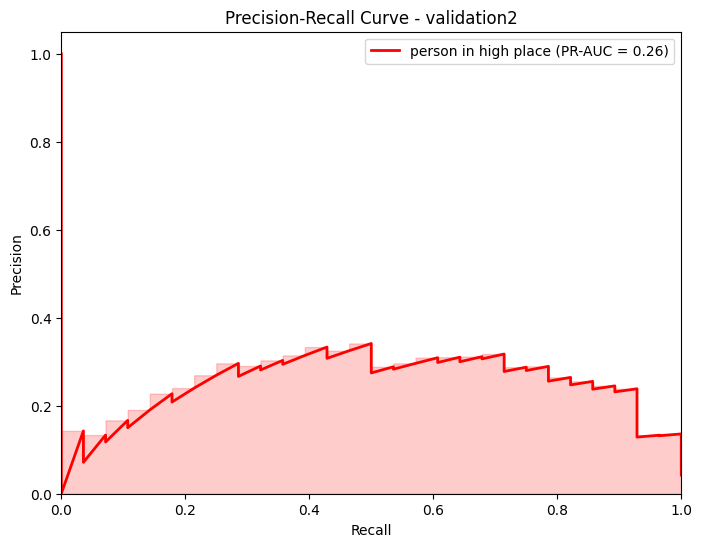

In [12]:
# PR-AUC
average_precision_cv_list = []
result_precision095_cv_list = []
cv_weight = []

for num_cv in range(3):
    print(f'validation: {num_cv}')
    plt.figure(figsize=(8, 6))
    for class_num, class_names in enumerate(class_category):
        if class_names in no_alarm_class_category:
            continue

        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])

        cv_weight.append(len(use_label))

        average_precision = average_precision_score(use_label, use_prob)
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        result_precision090 = [0.60, 0, 0] # precision, recall, threshold で保存
        result_precision095 = [0.65, 0, 0] # precision, recall, threshold で保存
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.60:
                result_precision090 = [p, r, t]
                break
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.65:
                result_precision095 = [p, r, t]
                break

        print(f'{class_names} - PR-AUC: {average_precision:.4f}')
        print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
        print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
        color = 'r'
        plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names} (PR-AUC = {average_precision:.2f})')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - validation{num_cv}')
    plt.legend(loc='best')
    plt.show()

    average_precision_cv_list.append(average_precision)
    result_precision095_cv_list.append(result_precision095)

In [13]:
sum([ap[1] * weight / sum(cv_weight) for ap, weight in zip(result_precision095_cv_list, cv_weight)])

0.021041147132169577

## テストデータで評価

In [14]:
labels_list = []
prob_list = []
test_df = pred_person_highplace_df[pred_person_highplace_df['validation'] == 999]
for num_cv in range(3):
    model = CatBoostClassifier()
    model.load_model(f'{highplace_model_dir}/{num_cv}/catboost.cbm')

    labels_np = test_df['label'].apply(classname2number).values
    prob_np = model.predict(test_df.iloc[:, 12:].values, prediction_type='Probability')
    labels_list.append(labels_np)
    prob_list.append(prob_np)

labels_np = labels_list[0]
prob_np = (prob_list[0] + prob_list[1] + prob_list[2]) / 3
prob_argmax = np.argmax(prob_np, axis=1)

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [15]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=class_category, columns=class_category
))

,detection-miss,person,person in high place
detection-miss,0,14,2
person,0,49,1
person in high place,0,20,16


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [16]:
def pred_class_names_precision095(row):
    no_safetybelt_threshold = row['threshold - person in high place']
    if row['person in high place'] >= no_safetybelt_threshold:
        return 'person in high place'
    return row[no_alarm_class_category].idxmax()

In [17]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
threshold_precision095_valid_dict = {}
for class_num, class_names in enumerate(class_category):
    if class_names in no_alarm_class_category:
            continue
    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    _threshold = 1.0
    for p, t in zip(precisions, thresholds):
        if p >= 0.85:
            _threshold = t
            break
    threshold_precision095_valid_dict[class_names] = _threshold
threshold_precision095_df = pd.DataFrame(
    [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(test_df))],
    columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=class_category), threshold_precision095_df], axis=1)

In [18]:
test_df['pred_person_in_highplace_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

/tmp/ipykernel_2865192/3969484369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_person_in_highplace_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))


In [19]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(test_df['pred_person_in_highplace_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=class_category, columns=class_category
))

,detection-miss,person,person in high place
detection-miss,0,13,3
person,0,48,2
person in high place,0,7,29


#### PR-AUC

person in high place - PR-AUC: 0.8236
precision@0.85 - Recall: 0.8056 - Threshold: 0.1771
precision@1.00 - Recall: 0.0556 - Threshold: 0.7190 



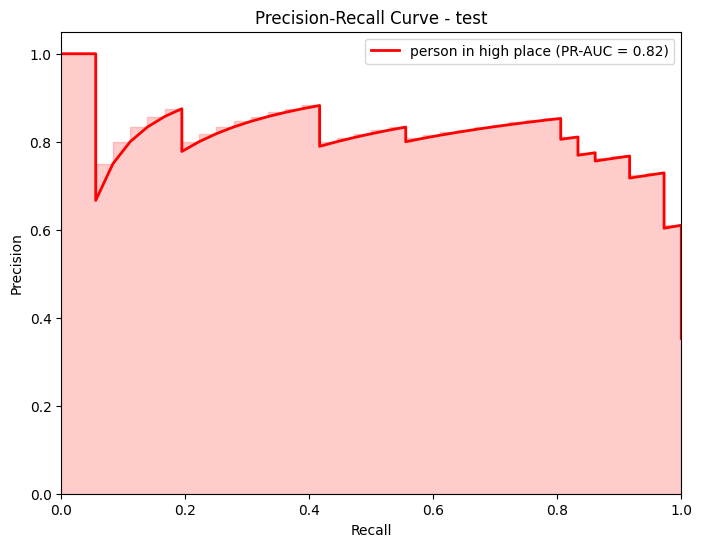

In [20]:
# PR-AUC
plt.figure(figsize=(8, 6))
for class_num, class_names in enumerate(class_category):
    if class_names in no_alarm_class_category:
            continue

    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])

    average_precision = average_precision_score(use_label, use_prob)
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    result_precision090 = [0.9, 0, 0] # precision, recall, threshold で保存
    result_precision095 = [0.95, 0, 0] # precision, recall, threshold で保存
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.85:
            result_precision090 = [p, r, t]
            break
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.9:
            result_precision095 = [p, r, t]
            break

    print(f'{class_names} - PR-AUC: {average_precision:.4f}')
    print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
    print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
    color = 'r'
    plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names} (PR-AUC = {average_precision:.2f})')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve - test')
plt.legend(loc='best')
plt.show()

In [21]:
pd.concat([valid_all_df, test_df]).to_csv(f'{result_dir}/pred_highplace_class-{pattern_date}.csv', index=False)